In [1]:

import pandas as pd
import ast
import json

# Load the business data

df = pd.read_csv("/Users/jaeeponde/dsm_project/philadelphia/philadelphia_restaurants_sampled.csv")

# Parse stringified dictionaries safely
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except:
        return {}

df['attributes'] = df['attributes'].apply(safe_literal_eval)

In [2]:
def flatten_attributes(attr_dict):
    flat = {}
    for key, val in attr_dict.items():
        if isinstance(val, str):
            try:
                parsed_val = ast.literal_eval(val)
                if isinstance(parsed_val, dict):
                    for sub_k, sub_v in parsed_val.items():
                        flat[f"{key}_{sub_k}"] = sub_v
                else:
                    flat[key] = parsed_val
            except:
                flat[key] = val
        elif isinstance(val, dict):
            for sub_k, sub_v in val.items():
                flat[f"{key}_{sub_k}"] = sub_v
        else:
            flat[key] = val
    return flat

flattened_attrs = df['attributes'].apply(flatten_attributes)
attr_df = pd.json_normalize(flattened_attrs)


In [3]:
# Convert booleans and strings to binary indicators
attr_df_clean = pd.get_dummies(attr_df, dummy_na=True)

# Drop columns with 0 variance
attr_df_clean = attr_df_clean.loc[:, attr_df_clean.nunique() > 1]

# Add stars for correlation
attr_df_clean['stars'] = df['stars']


In [4]:
# Drop columns that end with '_nan'
attr_df_clean = attr_df_clean.loc[:, ~attr_df_clean.columns.str.endswith('_nan')]


/var/folders/29/458ydd_j11q4vpw8md8c37fh0000gn/T/ipykernel_32540/1654962571.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')


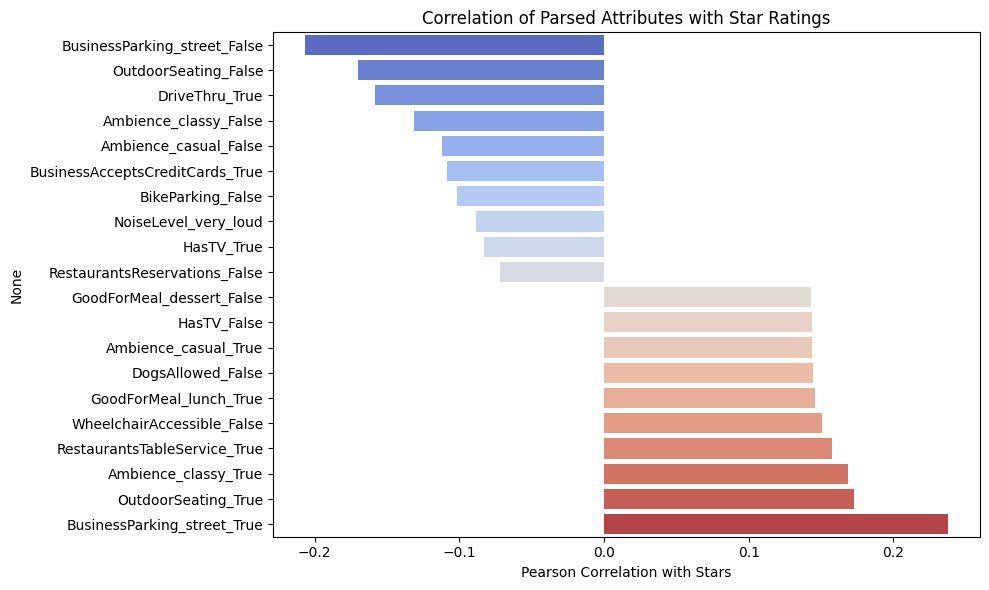

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation
corr = attr_df_clean.corr(numeric_only=True)['stars'].drop('stars').sort_values()

# Select top positive and negative correlations
top_corr = pd.concat([corr.head(10), corr.tail(10)])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')
plt.title('Correlation of Parsed Attributes with Star Ratings')
plt.xlabel('Pearson Correlation with Stars')
plt.tight_layout()
plt.show()

In [6]:
# Drop rows where categories are missing
df_categories = df.dropna(subset=['categories']).copy()

# Split categories into lists
df_categories['category_list'] = df_categories['categories'].apply(lambda x: [c.strip() for c in x.split(',')])

# One-hot encode all unique categories
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
category_matrix = mlb.fit_transform(df_categories['category_list'])

# Create DataFrame
category_df = pd.DataFrame(category_matrix, columns=mlb.classes_)
category_df['stars'] = df_categories['stars'].values

In [7]:
category_df

,Acai Bowls,Active Life,Afghan,African,American (New),American (Traditional),Arcades,Art Galleries,Arts & Crafts,Arts & Entertainment,...,Vegan,Vegetarian,Venues & Event Spaces,Vietnamese,Waffles,Whiskey Bars,Wine & Spirits,Wine Bars,Wraps,stars
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.5
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.5
596,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.5
597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,4.5
598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0


In [8]:
# Compute correlation with star ratings
cat_corr = category_df.corr(numeric_only=True)['stars'].drop('stars').sort_values()

cat_corr = cat_corr.dropna()

# Select top 10 positive and top 10 negative correlations
top_cat_corr = pd.concat([cat_corr.head(10), cat_corr.tail(10)])

/var/folders/29/458ydd_j11q4vpw8md8c37fh0000gn/T/ipykernel_32540/1294006652.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cat_corr.values, y=top_cat_corr.index, palette='coolwarm')


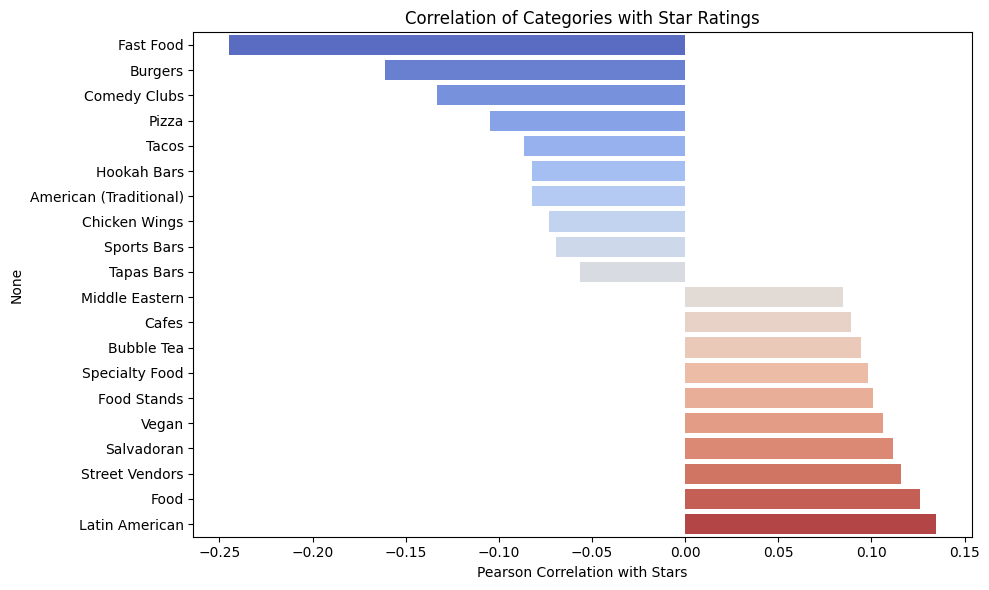

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=top_cat_corr.values, y=top_cat_corr.index, palette='coolwarm')
plt.title('Correlation of Categories with Star Ratings')
plt.xlabel('Pearson Correlation with Stars')
plt.tight_layout()
plt.show()